# Laboratorium 4

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

FIG_EPS = 0.5

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < FIG_EPS:
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Rozwiązanie
### Dodaj tu punkty i/lub odcinki!

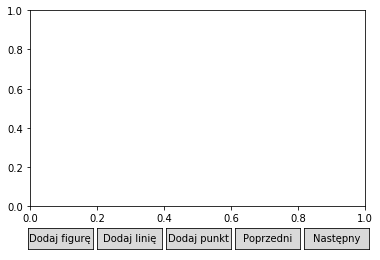

<Figure size 432x288 with 0 Axes>

In [3]:
plot_to_draw = Plot()
plot_to_draw.draw()

In [4]:
%matplotlib notebook

figure_from_previous_plot = plot_to_draw.get_added_figure()
scenes = [Scene([], figure_from_previous_plot)]

with open('first_plot.json', 'w') as file:
    file.write(Plot(scenes).toJson())

### Algorytm sprawdzania y-monotoniczności

In [6]:
%matplotlib notebook

def get_points_from_lines(lines):
    return [(line[0][0], line[0][1]) for line in lines]

def y(point): return point[1]

def find_min_max(points):
    min_y_i = max_y_i = 0
    
    for i in range(len(points)):
        p_y = y(points[i])
        if p_y < y(points[min_y_i]):
            min_y_i = i
        elif p_y > y(points[max_y_i]):
            max_y_i = i
    return min_y_i, max_y_i

def det(a,b,c):
    return a[0]*b[1] + a[1]*c[0] + b[0]*c[1] - b[1]*c[0] - a[1]*b[0] - a[0]*c[1]

def orient(a, b, c, eps=1e-6):
    orientation = det(a, b, c)
    if orientation < -eps:
        return -1
    elif orientation > eps:
        return 1
    else:
        return 0


def is_y_monotonic(points):
    min_point_i, max_point_i = find_min_max(points)
    i = max_point_i
    n = len(points)# we got from highest to the lowest so y(i+1) should always be lower or equal y(i)
    while i != min_point_i:
        if y(points[i+1]) > y(points[i]): return False
        i = (i + 1)%n
    i = max_point_i# Now we do the same but going different way
    while i != min_point_i:
        if y(points[i-1]) > y(points[i]): return False
        i = (i -1)%n
    return True


def divide_into_sets(points):
    min_point_i, max_point_i = find_min_max(points)
    set_1 = set()
    set_2 = set()
    i = max_point_i
    n = len(points)# we got from highest to the lowest so y(i+1) should always be lower or equal y(i)
    while i != min_point_i:
        set_1.add(points[i])
        i = (i + 1)%n
    i = max_point_i # Now we do the same but going different way
    while i != min_point_i:
        i = (i -1)%n
        set_2.add(points[i])
    return set_1, set_2

def is_in_the_same_set(point_1, point_2, set_1, set_2):
    return (point_1 in set_1 and point_2 in set_1) or (point_1 in set_2 and point_2 in set_2)
    
def connect(point_1, point_2):
    return point_1, point_2


def is_inside_figure(point_1, point_2, point_3):
    return True

    
def triangulate(lines, points):
    set_1, set_2 = divide_into_sets(points[0], points[-1], points)
    sorted_points = sorted(points, key= lambda x: x[1], reverse = True)
    stack = [points[0], points[1]]
    i = 2
    n = len(sorted_points)
    while i < n :
        point_3 = points[i]
        point_2 = stack.pop()
        point_1 = stack.pop()
        if not is_in_the_same_set(point_3, point_2, set_1, set_2):
            connect(point_3, point_2)
            connect(point_3, point_1)
            while len(stack) > 0:
                point_connecting = stack.pop()
                connect(point_3, point_connecting)
            stack += [point_2, point_3]
            i+=1
        else:
            if is_inside_figure(point_3, point_2, point_1):
                print('TODO')
            else:
                stack += [point_1, point_2, point_3]
                
                
            
            
                


with open('first_plot.json', 'r') as file:
    json = file.read()
helper_plot = Plot(json=json)
lines = helper_plot.scenes[0].lines[0].lines
figure_points = get_points_from_lines(lines)
is_figure_monotonic = is_y_monotonic(figure_points)
if is_figure_monotonic:
    triangulate(lines, figure_points)
helper_plot.draw()


IndexError: list index out of range